# Forecasting models

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import utils
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb

import lightgbm as lgb
import gluonts
from math import sqrt

import shap
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones


from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
from gluonts.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from pylab import rcParams
from sklearn.metrics import r2_score
# progress bar
from tqdm import tqdm, tqdm_notebook


#Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)

tuna_df = pd.read_csv(r'/Users/roopabharadwaj/Documents/CMU/mini_4/Machine Learning/Final project/consolidated_tuna_data_clean.csv', thousands = ',')
#tuna_df['dateInt']=tuna_df['year'].astype(str) + tuna_df['month'].astype(str).str.zfill(2)
#tuna_df['Date'] = pd.to_datetime(tuna_df['dateInt'], format='%Y%m')
tuna_df['date'] = pd.to_datetime(pd.to_datetime(tuna_df[['year', 'month']].assign(DAY=1)))
tuna_df.set_index('date',inplace=True)

2.4.1


**Prepare data before modeling**

In [2]:
#We split our dataset to be able to evaluate our models

resultsDict={}
predictionsDict={}

split_date ='2018-01-01'
df_training = tuna_df.loc[tuna_df.index <= split_date]
df_test = tuna_df.loc[tuna_df.index > split_date]
print(f"{len(df_training)} months of training data \n {len(df_test)} months of testing data ")

85 months of training data 
 36 months of testing data 


**Some functions**

In [3]:
EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """ Naive forecasting method which just repeats previous samples """
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """ Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:],
                      predicted[seasonality:]) / (_error(actual[seasonality:],
                                                         _naive_forecasting(actual,
                                                                            seasonality)) + EPSILON)

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """ Bounded Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """ Geometric mean """
    if not isinstance(
            a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Root Mean Squared Error """
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Error """
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """ Geometric Mean Absolute Error """
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """ Median Absolute Error """
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Percentage Error """
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(
        np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Error """
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Percentage Error """
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """ Root Mean Squared Scaled Error """
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """ Integral Normalized Root Squared Error """
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Relative Squared Error """
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(
        actual: np.ndarray,
        predicted: np.ndarray,
        benchmark: np.ndarray = None):
    """ Mean Relative Error """
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """ Relative Absolute Error (aka Approximation Error) """
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(
        actual: np.ndarray,
        predicted: np.ndarray,
        benchmark: np.ndarray = None):
    """ Mean Relative Absolute Error """
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(
        actual: np.ndarray,
        predicted: np.ndarray,
        benchmark: np.ndarray = None):
    """ Median Relative Absolute Error """
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(
        actual: np.ndarray,
        predicted: np.ndarray,
        benchmark: np.ndarray = None):
    """ Geometric Mean Relative Absolute Error """
    return _geometric_mean(
        np.abs(
            _relative_error(
                actual,
                predicted,
                benchmark)))


def mbrae(
        actual: np.ndarray,
        predicted: np.ndarray,
        benchmark: np.ndarray = None):
    """ Mean Bounded Relative Absolute Error """
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(
        actual: np.ndarray,
        predicted: np.ndarray,
        benchmark: np.ndarray = None):
    """ Unscaled Mean Bounded Relative Absolute Error """
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) ==
                    np.sign(predicted[1:] - predicted[:-1])).astype(int))


def bias(actual: np.ndarray, predicted: np.ndarray):
    """ Mean forecast error(or Forecast Bias) """
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray,
    predicted: np.ndarray,
    metrics=(
        "mae",
        "rmse",
        "mape",
        "r2")):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

It is also very important to include some naive forecast as the series mean to make sure our models perform better than the simplest of the simplest. 

We dont want to introduce any complexity if it does not provides any performance gain.

In [5]:
#Also add the naive mean average value
mean = df_test.skipjack_tuna_price.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.skipjack_tuna_price, mean)
predictionsDict['Naive mean'] = mean
print(resultsDict)

{'Naive mean': {'mae': 173.05555555555554, 'rmse': 213.96391180653703, 'mape': 0.13594814627865637, 'r2': 0.0}}


# Univariate time series analysis

In this section we will focus on time series forecasting methods capable of only looking at the target variable. 

This means no other regressors (more variables) can be added into the model.

### Auto Regression (AR)

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps. 

**Parameters of the model**:
**Number of AR (Auto-Regressive) terms (p)**: p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. 

For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

In [8]:
# Walk throught the test data, training and predicting 1 month ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.skipjack_tuna_price))):
    temp_train = tuna_df[:len(df_training)+t]
    model = AR(temp_train.skipjack_tuna_price)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test.skipjack_tuna_price, yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 36/36 [00:00<00:00, 163.66it/s]


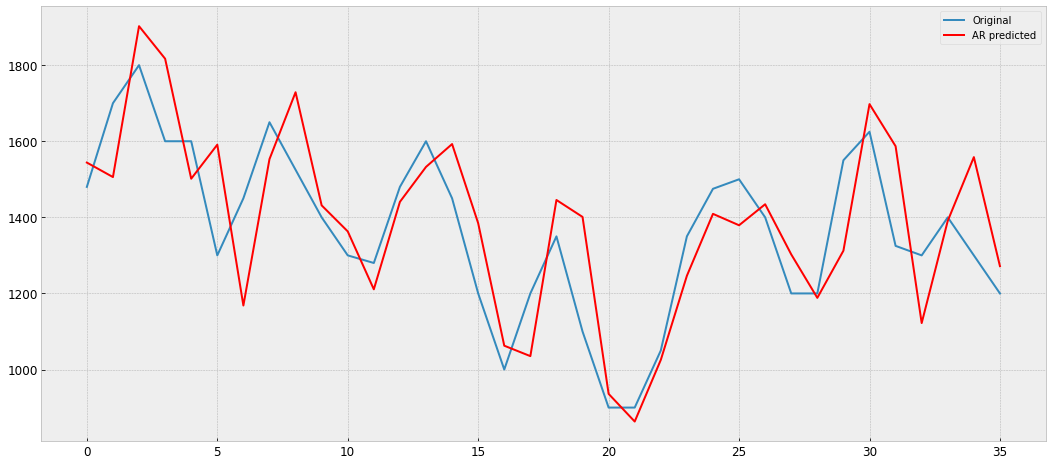

In [9]:
plt.plot(df_test.skipjack_tuna_price.values, label='Original')
plt.plot(yhat.values,color='red',label='AR predicted')
plt.legend()

### Autoregressive integrated moving average (ARIMA) <br>

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

*Number of AR (Auto-Regressive) terms (p)*: p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5). <br>

*Number of Differences (d)*: d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.<br>

*Number of MA (Moving Average) terms (q)*: q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. <br>

*Tuning ARIMA parameters* <br>
Non stationarity series will require level of differencing (d) >0 in ARIMA.  Selecting the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots AUTOARIMA <br>
Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [11]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Walk throught the test data, training and predicting 1 month ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.skipjack_tuna_price))):
    temp_train = tuna_df[:len(df_training)+t]
    model = ARIMA(temp_train.skipjack_tuna_price, order=(1,0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.skipjack_tuna_price, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 36/36 [00:02<00:00, 15.49it/s]


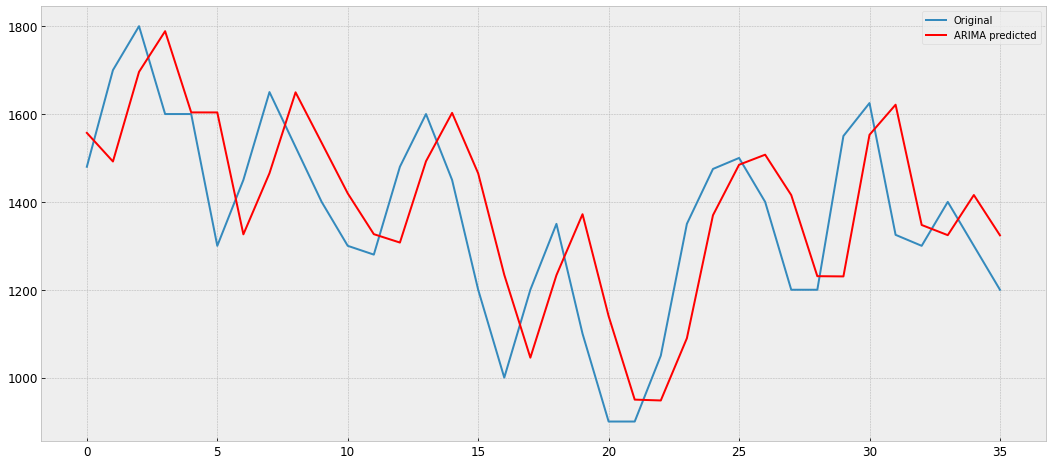

In [12]:
plt.plot(df_test.skipjack_tuna_price.values , label='Original')
plt.plot(yhat.values,color='red',label='ARIMA predicted')
plt.legend()

### Seasonal Autoregressive Integrated Moving-Average (SARIMA) <br>

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

*Trend Elements*:<nr>
There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:<br>
p: Trend autoregression order.<br>
d: Trend difference order.<br>
q: Trend moving average order.<br>
*Seasonal Elements*:<br>
There are four seasonal elements that are not part of ARIMA that must be configured; they are:<br>
P: Seasonal autoregressive order.<br>
D: Seasonal difference order.<br>
Q: Seasonal moving average order.<br>
m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.<br>

In [13]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.skipjack_tuna_price))):
    temp_train = tuna_df[:len(df_training)+t]
    model = SARIMAX(temp_train.skipjack_tuna_price, order=(1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test.skipjack_tuna_price, yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|██████████| 36/36 [00:01<00:00, 25.49it/s]


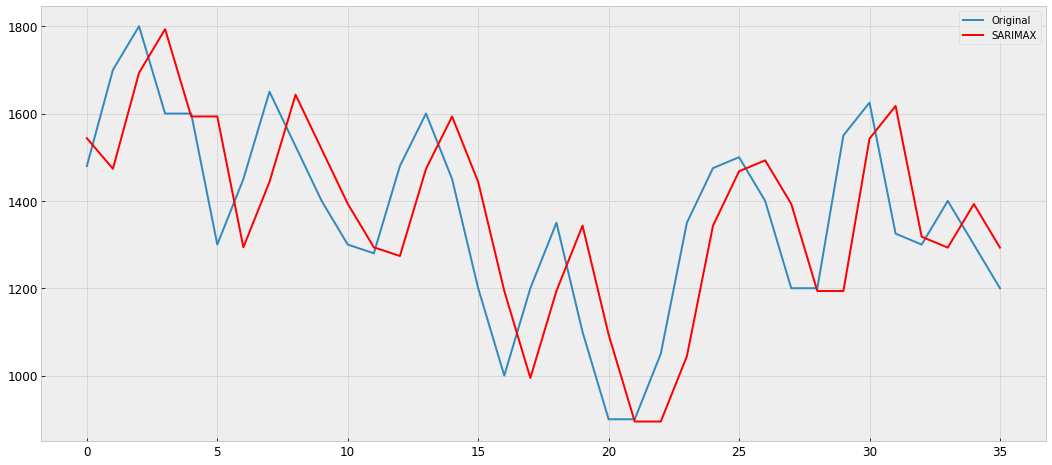

In [14]:
plt.plot(df_test.skipjack_tuna_price.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMAX')
plt.legend()

# Multivariate time series forecasting

In [16]:
## ADD time features to our model
def create_time_features(df,target=None):
    """
    Creates time series features from date index
    """
    df['date'] = df.index
    #df['month'] = df['date'].dt.month
    #df['quarter'] = df['date'].dt.quarter
    #df['year'] = df['date'].dt.year
    #df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'],axis=1)
    if target:
        y = df[target].astype(np.int64)
        X = X.drop([target],axis=1)
        return X, y
    
    return X

In [18]:
X_train_df, y_train = create_time_features(df_training, target='skipjack_tuna_price')
X_test_df, y_test = create_time_features(df_test, target='skipjack_tuna_price')
scaler = MinMaxScaler() 
scaler.fit(X_train_df)
X_train = scaler.fit_transform(X_train_df)  
X_test = scaler.fit_transform(X_test_df)

X_train_df = pd.DataFrame(X_train,columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test,columns=X_test_df.columns)

### Random Forest

In [19]:
reg = RandomForestRegressor(max_depth=5, random_state=100)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.skipjack_tuna_price, yhat)
predictionsDict['Randomforest'] = yhat

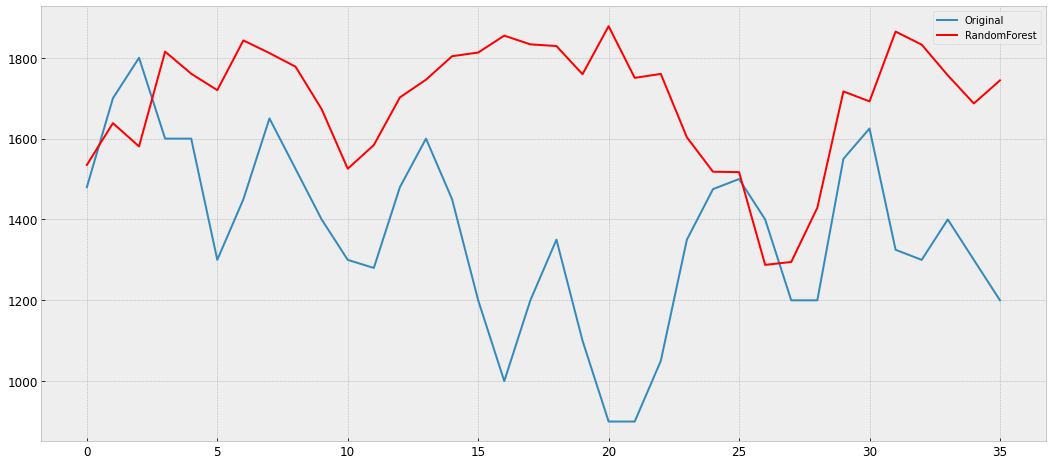

In [20]:
plt.plot(df_test.skipjack_tuna_price.values , label='Original')
plt.plot(yhat,color='red',label='RandomForest')
plt.legend()

### XGBoost

In [21]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(X_train, y_train,
       verbose=False) # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.skipjack_tuna_price, yhat)
predictionsDict['XGBoost'] = yhat

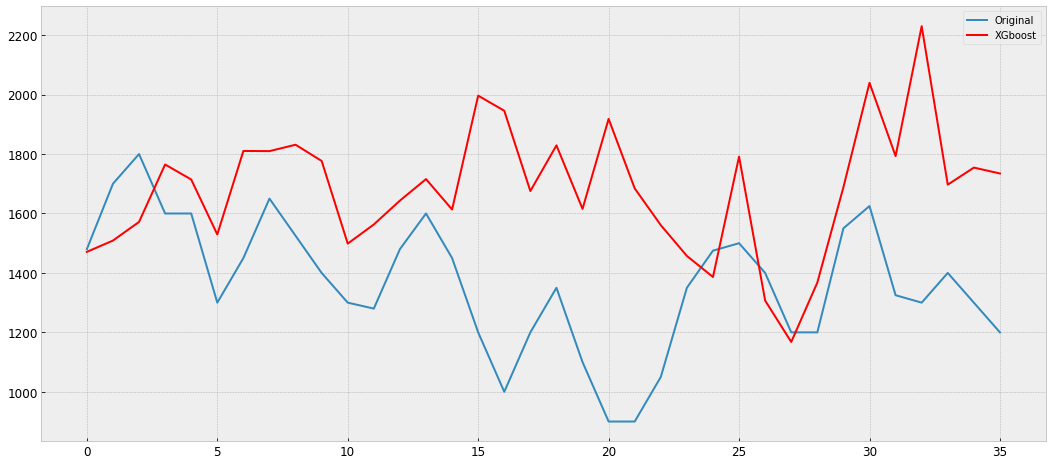

In [22]:
plt.plot(df_test.skipjack_tuna_price.values , label='Original')
plt.plot(yhat,color='red',label='XGboost')
plt.legend()

**Final plots**

In [23]:
import pickle
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

def bar_metrics(resultsDict):
    df = pd.DataFrame.from_dict(resultsDict)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    pallette = plt.cm.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))

    # MAE plot
    fig.add_subplot(2, 2, 1)
    df.loc["mae"].sort_values().plot(
        kind="bar", colormap="Paired", color=[
            color_dict.get(
                x, "#333333") for x in df.loc["mae"].sort_values().index], )
    plt.legend()
    plt.title("MAE Metric, lower is better")
    fig.add_subplot(2, 2, 2)
    df.loc["rmse"].sort_values().plot(
        kind="bar", colormap="Paired", color=[
            color_dict.get(
                x, "#333333") for x in df.loc["rmse"].sort_values().index], )
    plt.legend()
    plt.title("RMSE Metric, lower is better")
    fig.add_subplot(2, 2, 3)
    df.loc["mape"].sort_values().plot(
        kind="bar", colormap="Paired", color=[
            color_dict.get(
                x, "#333333") for x in df.loc["mape"].sort_values().index], )
    plt.legend()
    plt.title("MAPE Metric, lower is better")
    fig.add_subplot(2, 2, 4)
    df.loc["r2"].sort_values(ascending=False).plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333")
            for x in df.loc["r2"].sort_values(ascending=False).index
        ],
    )
    plt.legend()
    plt.title("R2 Metric, higher is better")
    plt.tight_layout()
    #plt.savefig("metrics.png")
    plt.show()

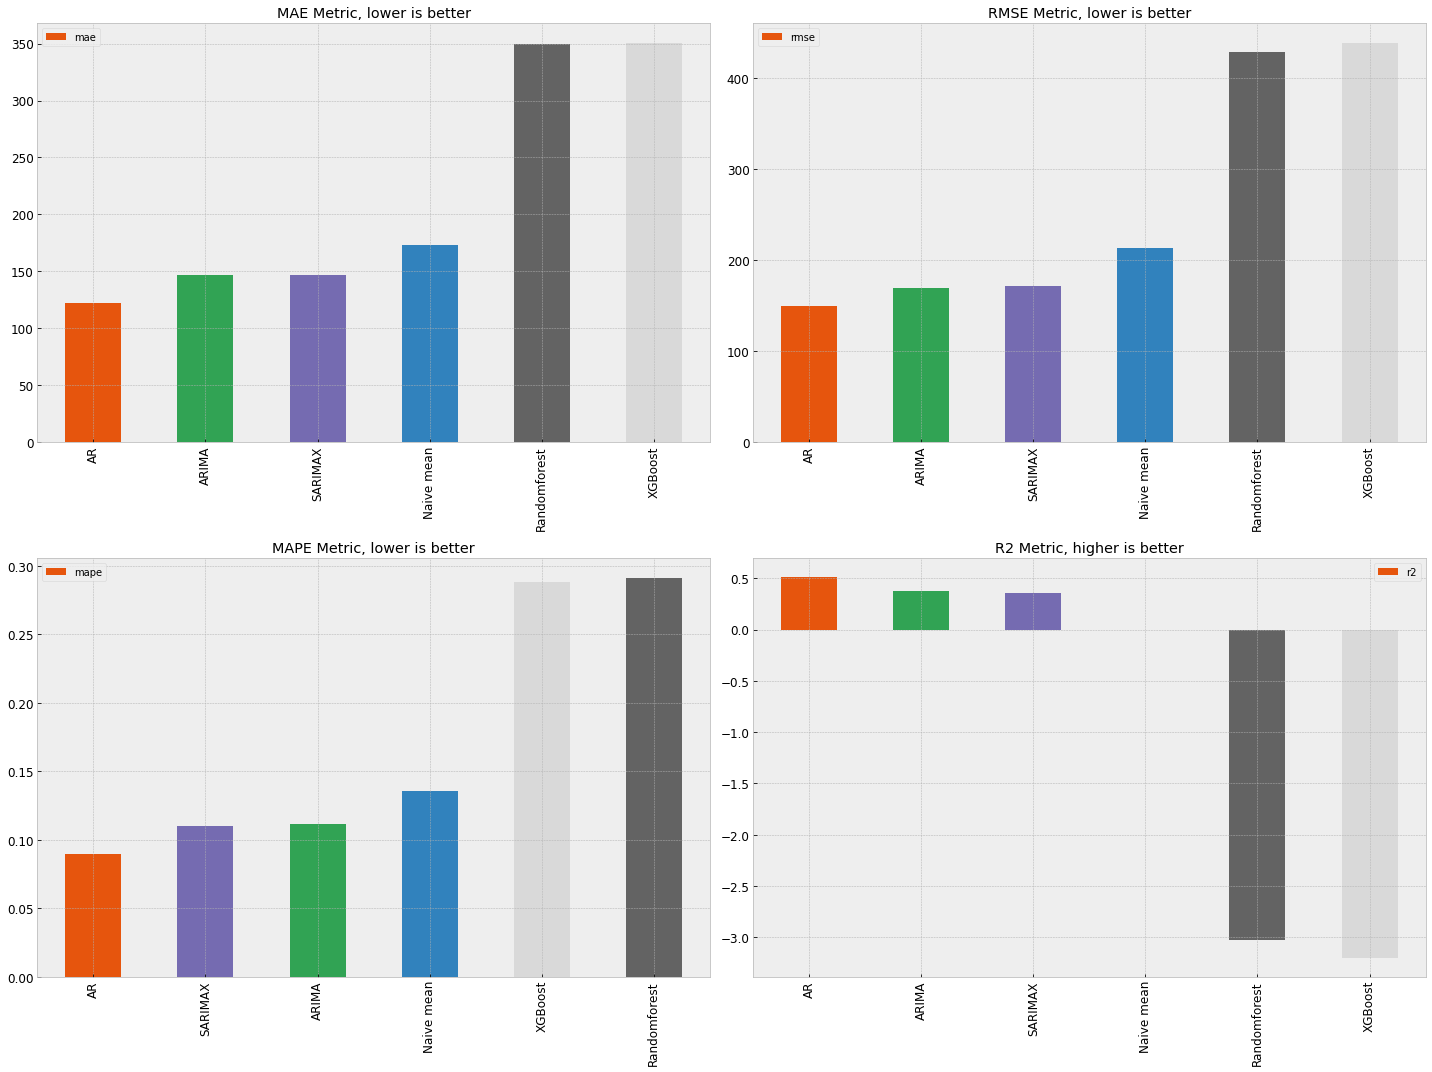

In [24]:
bar_metrics(resultsDict)